In [2]:
# libraries
from pymongo import MongoClient
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

import warnings
warnings.filterwarnings("ignore")

In [3]:
# connecting to the database
client=MongoClient(host="localhost", port=27017)
db=client["airquality"]
nairobi=db["nairobi"]

In [4]:
def wrangle(collection):
    
    result=collection.find({"value_type":"P2"},
                          projection={"value":1, "timestamp":1,  "_id":0})
    
    df=pd.DataFrame(result).set_index("timestamp")
        
    df.index=pd.to_datetime(df.index)
    
    #renaming column
    df.rename(columns={"value":"P2"}, inplace=True)
    
  
    #localize time to nairobi
    df.index=df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")  
        
    #according to Department of Health, the hazardous airquality is between 301-500
    df=df[df["P2"]<500] 
    
    #resampling data for hourly prediction
    y=df["P2"].resample("1H").mean()
    
    return y

In [5]:
y=wrangle(nairobi)

In [6]:
assert isinstance(y, pd.Series)
assert y.isnull().sum()==0

# Explore

In [7]:
y.corr(y.shift(10))

0.2680652584607869

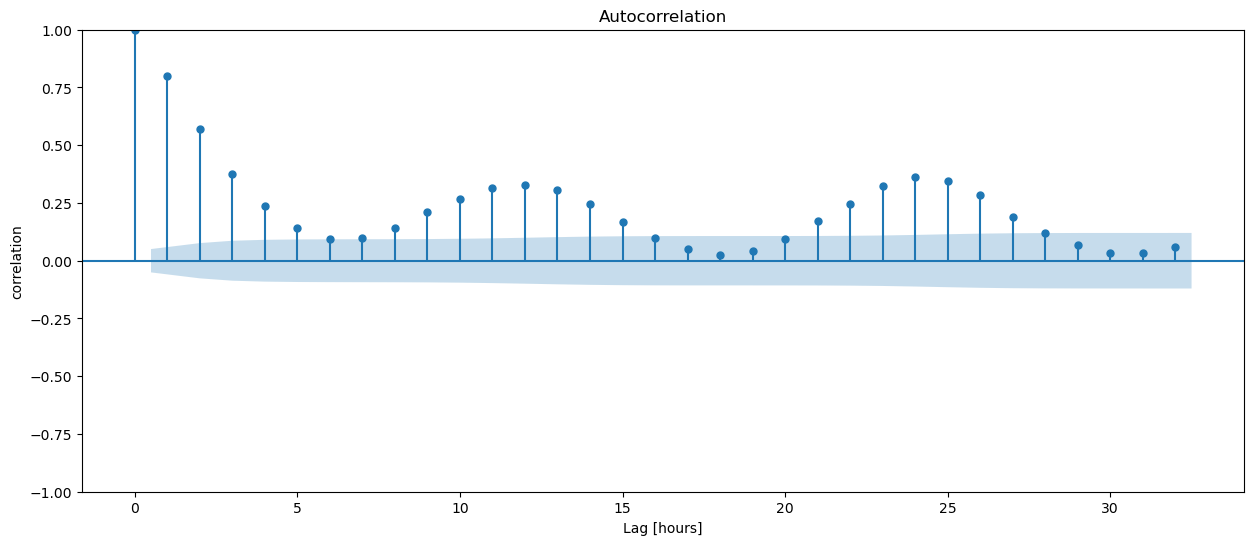

In [8]:
# looking at correlation between the target and some hours back
fig, ax=plt.subplots(figsize=(15,6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("correlation");

In [9]:
y.shift(1).corr(y.shift(2))

0.8001573262108749

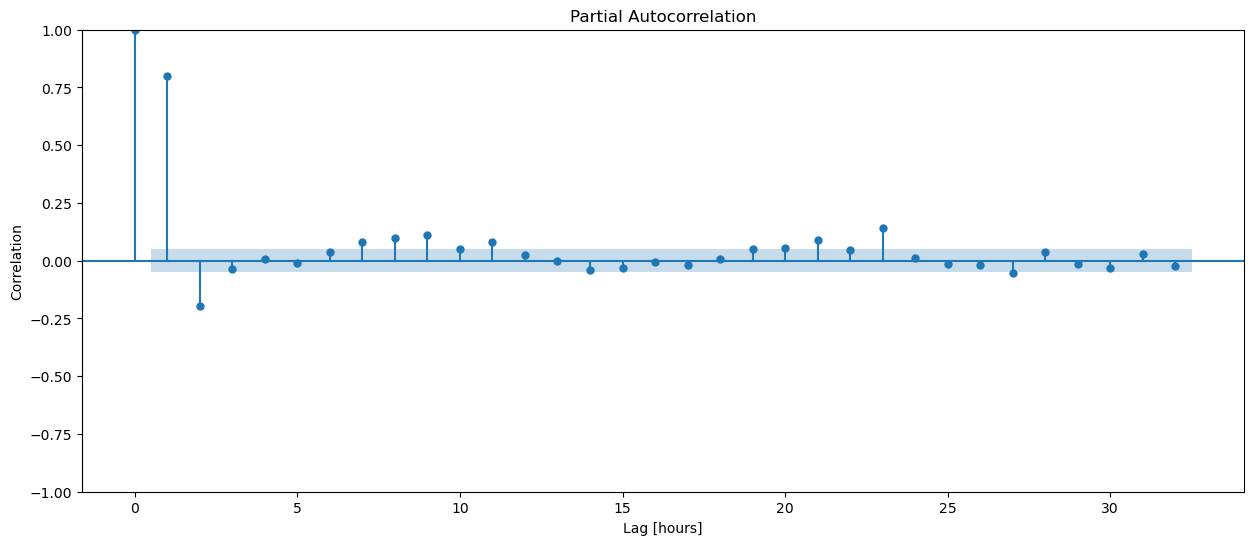

In [10]:
# checking for predictive power
fig, ax=plt.subplots(figsize=(15,6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation");

## Split data


In [11]:
cutoff=int(len(y)*0.95)

y_train=y.iloc[:cutoff]
y_test=y.iloc[cutoff:]

## Build the Model

### Baseline

In [12]:
y_mean=y_train.mean()
y_pred_baseline=[y_mean] * len(y_train)

print("Baseline MAE score", round(mean_absolute_error(y_train,y_pred_baseline), 2))

Baseline MAE score 3.43


## Iterate

In [13]:
model=AutoReg(y_train, lags=24).fit()

In [14]:
y_pred=model.predict().dropna()
print("Training MAE", round(mean_absolute_error(y_train.iloc[24:], y_pred), 2))

Training MAE 1.69


In [15]:
y_train_resid=model.resid
y_train_resid

timestamp
2018-11-02 03:00:00+03:00   -0.470399
2018-11-02 04:00:00+03:00    2.207598
2018-11-02 05:00:00+03:00    2.335524
2018-11-02 06:00:00+03:00    0.304085
2018-11-02 07:00:00+03:00    2.211137
                               ...   
2018-12-30 11:00:00+03:00   -0.666586
2018-12-30 12:00:00+03:00   -0.499371
2018-12-30 13:00:00+03:00   -0.927883
2018-12-30 14:00:00+03:00   -0.804332
2018-12-30 15:00:00+03:00   -1.057997
Freq: h, Length: 1405, dtype: float64

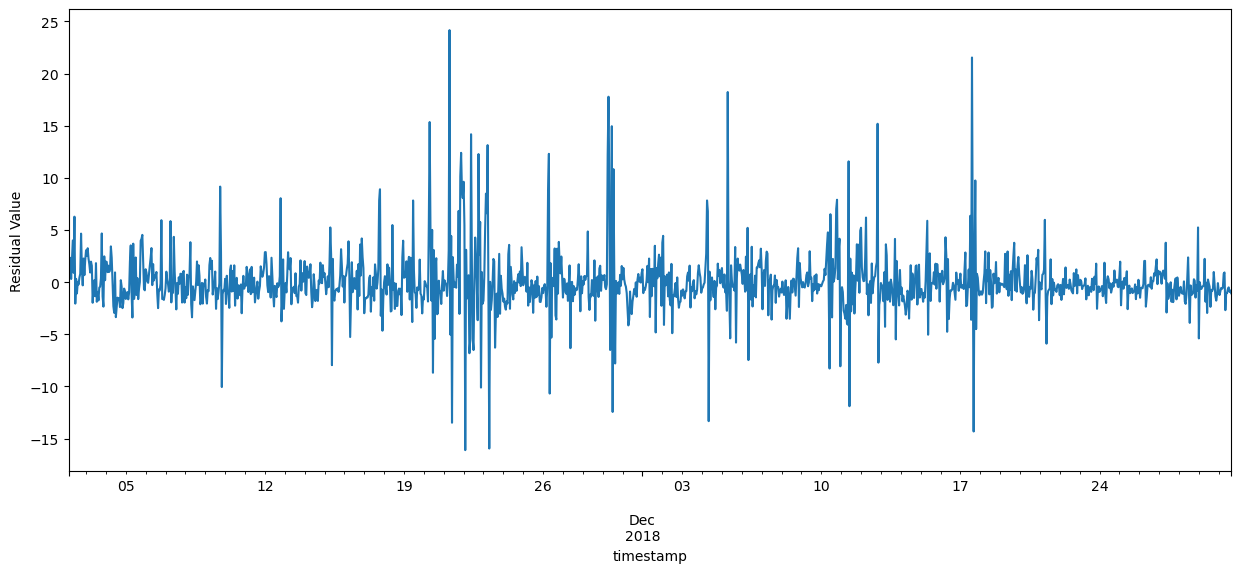

In [16]:
fig, ax=plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual Value", ax=ax);

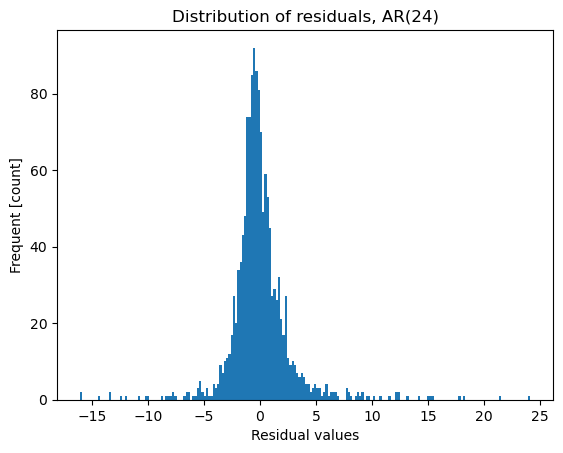

In [17]:
y_train_resid.hist(bins=200, grid=False)
plt.xlabel("Residual values")
plt.ylabel("Frequent [count]")
plt.title("Distribution of residuals, AR(24)");

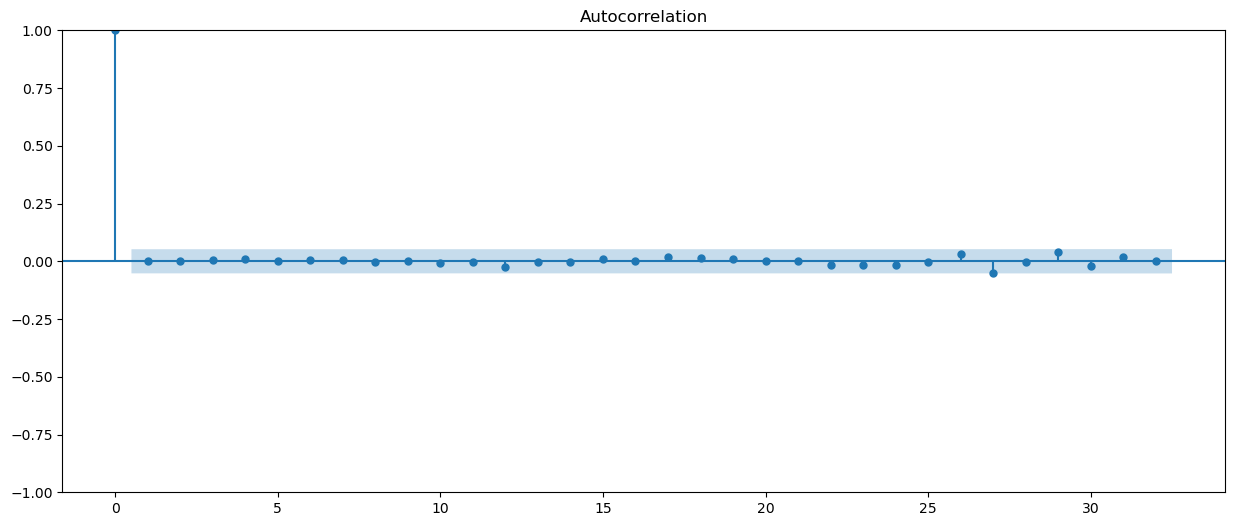

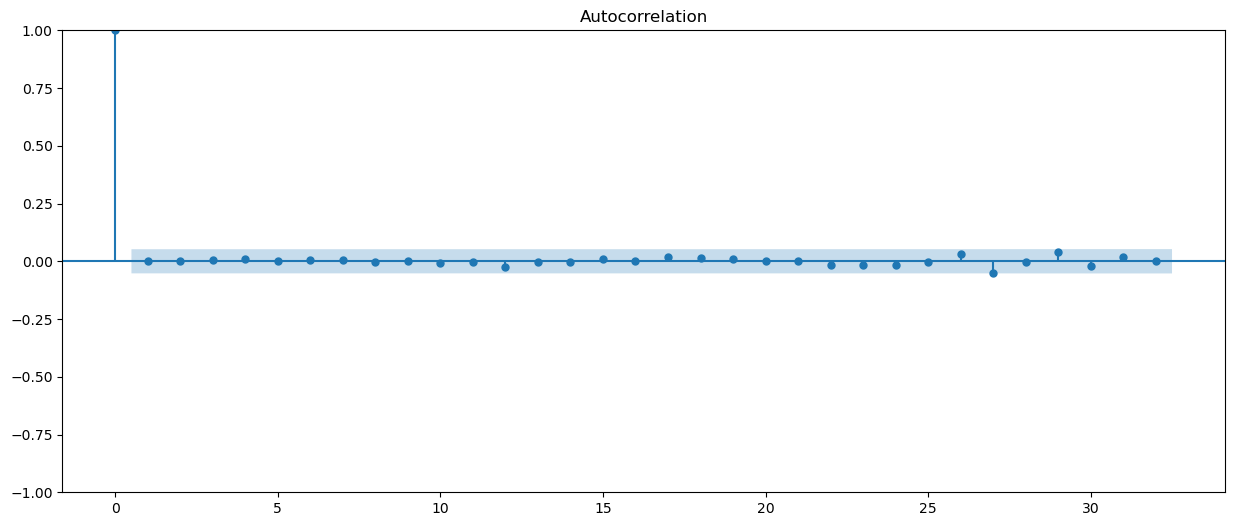

In [18]:
fig, ax=plt.subplots(figsize=(15,6))
plot_acf(y_train_resid, ax=ax)

## Evaluate

In [19]:
y_pred_wfv=pd.Series()
history=y_train.copy()
for i in range(len(y_test)):
    model=AutoReg(history, lags=24).fit()
    next_pred=model.forecast()
    y_pred_wfv=y_pred_wfv._append(next_pred)
    history=history._append(y_test[next_pred.index])

In [89]:
print("Test MAE ", round(mean_absolute_error(y_test, y_pred_wfv), 2))

Test MAE  0.97


# Communicate Result

In [85]:
model.params

const     0.935008
P2.L1     0.892114
P2.L2    -0.155141
P2.L3    -0.031401
P2.L4     0.027682
P2.L5    -0.018940
P2.L6    -0.011482
P2.L7     0.005915
P2.L8     0.000543
P2.L9     0.073387
P2.L10   -0.033709
P2.L11    0.050532
P2.L12    0.005394
P2.L13    0.034877
P2.L14   -0.023289
P2.L15   -0.025985
P2.L16    0.013927
P2.L17   -0.015528
P2.L18   -0.023940
P2.L19    0.012510
P2.L20   -0.016708
P2.L21    0.072075
P2.L22   -0.081876
P2.L23    0.132043
P2.L24    0.012877
dtype: float64

<font size="+1">$$y_{t} = \beta_{0} +\beta_{1} * P2.L2 + \beta_{2} * P2.L3 \cdots +\beta_{24} * P2.L24 $$

In [83]:
df_pred_testpd=pd.DataFrame({'y_test':y_test, 'y_pred_wfv':y_pred_wfv}, index=y_test.index)
fig = px.line(df_pred_testpd)
fig.show()